In [1]:
# Importing libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import *
from sklearn.metrics import *
from tensorflow.keras import *
from keras.models import load_model
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Loading Training Data
training_dir = 'Training/'
training_paths = []

train_labels = []

for label in os.listdir(training_dir):
    for file in os.listdir(training_dir+label):
        training_paths.append(training_dir+label+'/'+file)
        train_labels.append(label)
random.shuffle(training_paths)
random.shuffle(train_labels)


# show an example of the list
training_paths[0]

'Training/notumor/Tr-no_1273.jpg'

In [3]:
len(training_paths)

5712

In [4]:
# Loading Testing/Validation Data
test_dir = 'Testing/'
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
        test_labels.append(label)
random.shuffle(test_paths)
random.shuffle(test_labels)

# test_paths, test_labels = shuffle(test_paths, test_labels)

# show an example of the list
print(test_paths[0])

Testing/notumor/Te-no_0286.jpg


In [5]:
len(test_paths)

1311

In [6]:
labels = os.listdir(training_dir)
labels

['glioma', 'meningioma', 'notumor', 'pituitary']

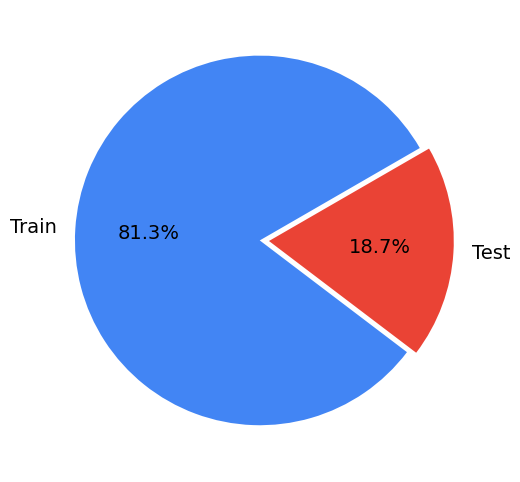

In [7]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [8]:
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(256,256))
        image = image.convert('RGB')
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

def get_labels(paths):
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

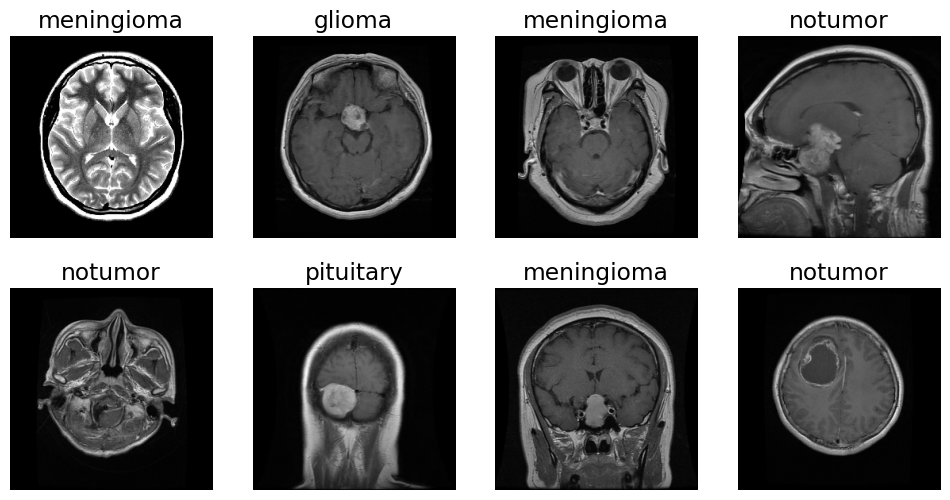

In [9]:
# i = random.randint(0,len(training_paths))
images = open_images(training_paths[60:69])
xlabels = train_labels[60:69]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(xlabels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 10})
plt.show()

In [10]:
# Expand the size of a training set by creating modified data from existing one
def data_gen(data_paths, batch_size=10):
    '''
    Given the image paths, it yields the images with the respective labels, as a batch
    '''
    for i in range(0, len(data_paths), batch_size):
        paths = data_paths[i:i+batch_size]
        images = open_images(paths)
        labels = get_labels(paths)
        yield images,np.array(labels)

In [11]:
# Loading the Pre-Trained Model (ResNet152V2)

base_model = ResNet152V2(input_shape = (256,256,3), 
                                                include_top = False, 
                                                weights = 'imagenet' )
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [12]:
len (base_model.layers)

564

In [13]:
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
    
# Set the last InceptionV3 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [14]:
model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 75,109,508
Trainable params: 17,832,580
No

In [15]:
len (model.layers)

6

In [16]:
#!pip install pydot
plot_model(model, show_shapes=True, to_file="Model Layers/resnet.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


6. TRAINING THE MODEL

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                                loss='sparse_categorical_crossentropy', 
                                metrics=['sparse_categorical_accuracy'])

In [18]:
# Training the Model

batch_size=256

history = model.fit(data_gen(training_paths), 
epochs=30,
steps_per_epoch=int(len(training_paths)/batch_size), 
validation_data= data_gen(test_paths),
validation_steps=int(len(test_paths)/batch_size)
 )

Epoch 1/30
22/22 [==============================] - 67s 2s/step - loss: 1.5394 - sparse_categorical_accuracy: 0.6727 - val_loss: 1.6247 - val_sparse_categorical_accuracy: 0.7000
Epoch 2/30
22/22 [==============================] - 50s 2s/step - loss: 0.9222 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.5746 - val_sparse_categorical_accuracy: 0.8600
Epoch 3/30
22/22 [==============================] - 47s 2s/step - loss: 0.9323 - sparse_categorical_accuracy: 0.8091 - val_loss: 1.4317 - val_sparse_categorical_accuracy: 0.7000
Epoch 4/30
22/22 [==============================] - 46s 2s/step - loss: 0.6989 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.5948 - val_sparse_categorical_accuracy: 0.9200
Epoch 5/30
22/22 [==============================] - 46s 2s/step - loss: 0.5959 - sparse_categorical_accuracy: 0.8636 - val_loss: 0.3204 - val_sparse_categorical_accuracy: 0.9000
Epoch 6/30
22/22 [==============================] - 47s 2s/step - loss: 0.4925 - sparse_categorical_accuracy: 

In [19]:
model.save('resnet.h5')

In [20]:
model = load_model ('resnet.h5')

In [21]:
evaluation = model.evaluate(data_gen(test_paths))

print('Test Loss:', evaluation[0])
print ('Test Accuracy:', evaluation[1])

132/132 [==============================] - 210s 2s/step - loss: 0.1542 - sparse_categorical_accuracy: 0.9443
Test Loss: 0.15417605638504028
Test Accuracy: 0.9443173408508301


In [22]:
evaluation = model.evaluate(data_gen(training_paths))

print('train Loss:', evaluation[0])
print ('train Accuracy:', evaluation[1])

572/572 [==============================] - 922s 2s/step - loss: 0.0550 - sparse_categorical_accuracy: 0.9820
train Loss: 0.05495225638151169
train Accuracy: 0.9819678068161011


1/1 [==============================] - 3s 3s/step
Predicted: pituitary
Actual: pituitary


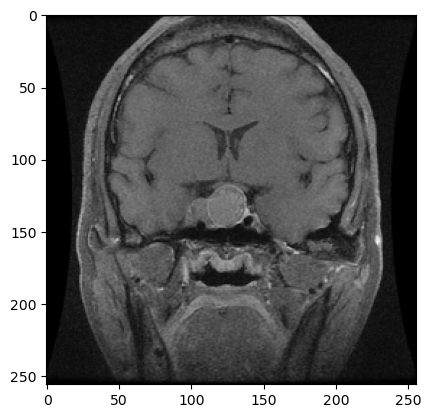

In [23]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)

In [24]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


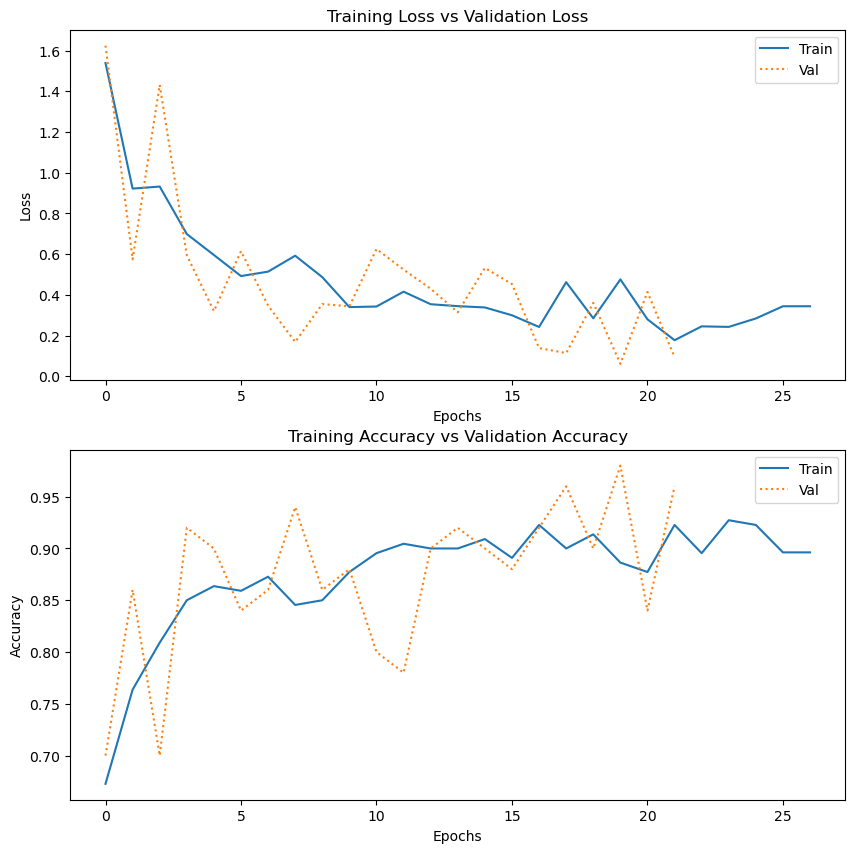

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'], linestyle='dotted')
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['sparse_categorical_accuracy'])
axs[1].plot(history.history['val_sparse_categorical_accuracy'], linestyle='dotted')
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [26]:
# For Classification Report

test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(test_dir, target_size=(256,256), shuffle=False, seed=21,
                                                     class_mode='sparse', batch_size=16)

Found 1311 images belonging to 4 classes.


In [27]:
classes = labels
#On test dataset
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

82/82 [==============================] - 198s 2s/step


In [28]:
#Classification Report

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      glioma       0.95      0.89      0.92       300
  meningioma       0.89      0.88      0.89       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [29]:
# For Confusion Matrix
target_labels = ["glioma", "meningioma", "notumor", "pituitary"]

Generator = ImageDataGenerator(rescale=1./255)
test_gen = Generator.flow_from_directory(test_dir,
                                        # resizing testing images to (min(heights), min(widths)) in both trainining and testing sets
                                          target_size = (256,256),
                                          color_mode = 'rgb',
                                          classes = target_labels,
                                          class_mode = 'sparse',
                                          batch_size = 16,
                                          shuffle = False,
                                         )

Found 1311 images belonging to 4 classes.


In [30]:
def test_model(model, test_generator):
    y_pred = model.predict(x = test_generator, verbose = 1)
    print(y_pred.shape)
    print(y_pred[:10])
    return y_pred

In [31]:
y_pred = test_model(model, test_gen)
print(y_pred[:10])

82/82 [==============================] - 197s 2s/step
(1311, 4)
[[9.99473870e-01 1.08032864e-05 5.15145599e-04 6.89525326e-09]
 [9.95463371e-01 3.82170593e-03 5.16877626e-04 1.98051581e-04]
 [9.97761607e-01 2.14151270e-03 9.38479279e-05 2.97776569e-06]
 [2.63877660e-01 2.49541223e-01 1.78678334e-02 4.68713224e-01]
 [8.05796206e-01 9.91547331e-02 2.88819429e-02 6.61670640e-02]
 [9.74938512e-01 1.92363821e-02 5.76937431e-03 5.57125022e-05]
 [9.99895513e-01 1.03895756e-04 4.43978962e-07 5.79372017e-09]
 [9.99998510e-01 5.14834596e-07 9.33197612e-07 9.53062784e-09]
 [9.92425263e-01 6.37690630e-03 1.19218064e-04 1.07857853e-03]
 [9.98002231e-01 1.94361631e-03 4.56562375e-05 8.45712839e-06]]
[[9.99473870e-01 1.08032864e-05 5.15145599e-04 6.89525326e-09]
 [9.95463371e-01 3.82170593e-03 5.16877626e-04 1.98051581e-04]
 [9.97761607e-01 2.14151270e-03 9.38479279e-05 2.97776569e-06]
 [2.63877660e-01 2.49541223e-01 1.78678334e-02 4.68713224e-01]
 [8.05796206e-01 9.91547331e-02 2.88819429e-02 6.6167

In [32]:
Y_pred = (y_pred > 0.5).astype(int)
print(Y_pred[:10])

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [33]:
print(test_gen.labels[:10])

[0 0 0 0 0 0 0 0 0 0]


In [34]:
labelBinarizer = LabelBinarizer()
test_labels = labelBinarizer.fit_transform(test_gen.labels)
print(test_labels[:10])

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [35]:
def plot_cf_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 10):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class : " + class_label)

In [36]:
def plot_confusion_matrices(conf_matrices, target_labels):
    fig, ax = plt.subplots(1, len(target_labels), figsize = (15, 5))

    for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrices, target_labels):
        plot_cf_matrix(cfs_matrix, axes, label, ["POSITIVE", "NEGATIVE" ])

    fig.tight_layout()
    plt.show()

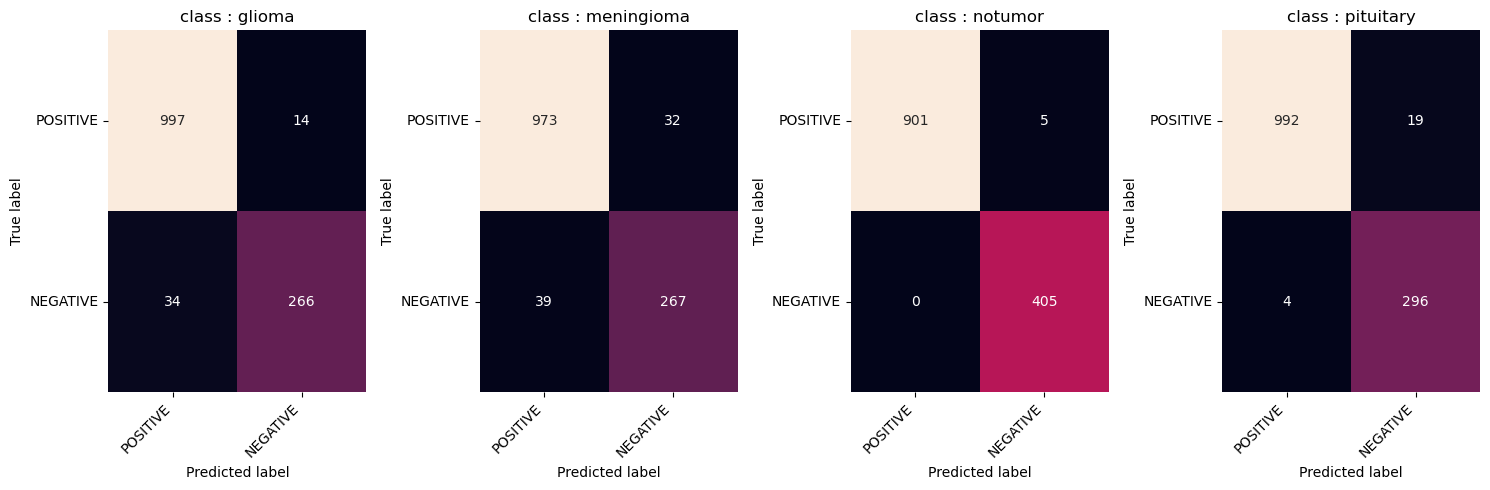

In [37]:
# Confusion Matrix for each class

conf_matrices = multilabel_confusion_matrix(y_true = test_labels, y_pred = Y_pred, labels = [0, 1, 2, 3])
plot_confusion_matrices(conf_matrices, target_labels)